# Tic Tac Toe graph

I've always been curious to graph the game tree of Tic Tac Toe, in order to see just how many positions are wins and how many are losses.

...there's just one thing - complexity. At the end of the game, all 9 squares will be filled with either X or O, meaning there are 2**9 (512) possible endgame boards, as well as all the possible boards along the way... but of course, there has to be an equal number of Xs and Os (roughly), so it must be less than that... and because the board is rotationally symmetrical and mirrored, we can ignore many of the boards as duplicates... oh boy, this is gonna be quite the problem.

In order to study the complexity of Tic Tac Toe, I'm going to develop a full game tree of all possible boards in order to study different strategies.

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import networkx as nx

In [ ]:
class Tictactoe: 
  def __init__(self, board = None, xturn = None):
    if(board == None):
      self.board = [' ' for x in range(9)]
    else:
      self.board = board
    if(xturn == None):
      self.xturn = True #I don't know what the convention is, but I'm gonna guess X goes first
    else:
      self.xturn = xturn
  def __str__(self):
    b = self.board
    return f"\n{b[0]}│{b[1]}│{b[2]}\n─┼─┼─\n{b[3]}│{b[4]}│{b[5]}\n─┼─┼─\n{b[6]}│{b[7]}│{b[8]}"
  def __repr__(self):
    return "Tictactoe(board = " + repr(self.board) + ", xturn = " + repr(self.xturn) + ")" #I don't care
  def _truehash(self): #Finds the exact hash of a board position, NOT accounting for symmetry.
    output = 0
    for x in self.board:
      output += {' ':1, 'X':2, 'O':3}[x]
      output *= 5
    if self.xturn:
      output += 1
    return output
  def __hash__(self): #important so that we can use these as dict keys
    return min([Tictactoe._truehash(x) for x in self.mirrors()]) #return the lowest hash out of all mirrors of the board. THIS MEANS ROTATIONALLY EQUIVALENT BOARDS HAVE THE SAME HASH
  def hashboard(self): #same as hash but returns the board
    return min([x for x in self.mirrors()], key=Tictactoe._truehash)
  def move(self, position): #returns a new board with a new move in the specified position and xturn toggled
    newboard = list(self.board)
    newboard[position] = "OX"[self.xturn]
    newxturn = not self.xturn
    return Tictactoe(board = newboard, xturn = newxturn)
  def emptyspots(self): #generates each empty spot
    output = []
    for x in range(len(self.board)):
      if(self.board[x] == ' '):
        output.append(x)
    return output
  def moves(self): #iterates over possible future moves
    if(self.iswin()):
      return tuple()
    return tuple(self.move(x) for x in self.emptyspots())
  def mirrors(self): #generates all possible rotations and reflections of a board
    b = self.board

    donothing = lambda b:b
    mirrorx = lambda b:[b[2], b[1], b[0], b[5], b[4], b[3], b[8], b[7], b[6]]
    mirrory = lambda b:[b[6], b[7], b[8], b[3], b[4], b[5], b[0], b[1], b[2]]
    rotate  = lambda b:[b[6], b[3], b[0], b[7], b[4], b[1], b[8], b[5], b[2]]
    
    for x in (donothing, mirrorx):
      for y in (donothing, mirrory):
        for r in (donothing, rotate):
          yield Tictactoe(board = x(y(r(b))), xturn = self.xturn)
  def iswin(self): #returns 'X' or 'O' if they win, returns False if nobody is winning, returns True if board is full
    b = self.board #just to make things more compact
    for x in range(0, 9, 3): #iterate over rows
      if(b[x] == b[x+1] and b[x+1] == b[x+2] and b[x] != ' '):
        return b[x]
    for x in range(3): #iterate over columns
      if(b[x] == b[x+3] and b[x+3] == b[x+6] and b[x] != ' '):
        return b[x]
    if(b[0] == b[4] and b[4] == b[8] and b[0] != ' '): #top left to bottom right diagonal
      return b[0]
    if(b[2] == b[4] and b[4] == b[6] and b[2] != ' '):
      return b[2]
    if(all([x != " " for x in b])): #if all squares full
      return True
    return False
  def almostwin(self): #if the current player can instantly win, this returns the position of that move. otherwise, False
    for x in self.emptyspots():
      if(self.move(x).iswin() in ('X', 'O')):
        return x
    return False
  def almostalmostwin(self): #if there is a move that, no matter what the enemy does, makes our next turn an almost win, return it, otherwise False
    for x in self.emptyspots():
      if(all([y.almostwin() for y in self.move(x).moves()])):
        return x
    return False
  def bestmove(self): #recursively searches the game tree - returns a list of all possible moves that will eventually win for the current player
    me = "OX"[self.xturn]
    #first - check if an instant win is possible
    output = []
    for x in self.emptyspots():
      if(self.move(x).iswin() == me):
        output.append(x)
    if(len(output) != 0):
      return output
    #if not, recurse.
    for x in self.emptyspots(): #for each move I could make
      enemymoves = [y for y in self.move(x).moves()] #all possible enemy responses
      if any([move.iswin() for move in enemymoves]): #if any enemy moves are wins...
        continue #do not consider this X
      if all([move.bestmove() != False for move in enemymoves]):
        output.append(x)
          
    if(output == []): #if a win cannot be guaranteed
      return False
    return output
      

    

  def __eq__(self, other):
    return (self.board == other.board) and (self.xturn == other.xturn)

def printb(boards):
  for b in boards:
    print(b, '\n')

In [ ]:
def getall(x): #returns a dict of every possible position starting at X by recursing over positions and merging dicts. use .values()!
  if x.iswin():
    return {}
  output = {}
  for n in x.moves():
    h = hash(n)
    if h not in output:
      output[h] = n
      output.update(getall(n))
  return output

everyposition = [] #another way of doing it, using global variables. Faster, but harder to follow.
everypositionset = set()
def rec(x):
  if x.iswin():
    return
  for n in x.moves():
    h = hash(n)
    if h not in everypositionset:
      everypositionset.add(h)
      everyposition.append(n)
      rec(n)

rec(Tictactoe()) #THIS STEP BUILDS THE GAME TREE INTO everyposition!

#board = [' ', 'X', ' ', ' ', 'O', 'X', 'O', ' ', ' ', ] as an example argument for Tictactoe

everyposition.append(Tictactoe()) #don't forget to include the starting position!

#everyposition = list(getall(Tictactoe()).values())

print("Total positions: ", len(everyposition))
print("X wins: ", len([x for x in everyposition if x.iswin() == 'X']))
print("O wins: ", len([x for x in everyposition if x.iswin() == 'O']))
print("Draws: ", len([x for x in everyposition if x.iswin() == True]))

Total positions:  765
X wins:  91
O wins:  44
Draws:  3


In [ ]:
#everyposition = [x for x in everyposition if x.iswin() == False] #filter out only the non-ending positions

In [ ]:
#...let's take everyposition and sort it by number of moves made, shall we? This should produce a nicer graph... and let's also sort by hash, so similar boards are closer together!
everyturn = [[] for x in range(10)]
for x in everyposition:
  everyturn[len(x.emptyspots())].append(x)

everyturn = [x for x in everyturn if len(x)] #get rid of empty rows

for i in range(len(everyturn)):
  everyturn[i].sort(key=hash)

print("Node counts:")
for x in everyturn:
  print(len(x))

Node counts:
15
57
153
204
174
108
38
12
3
1


In [ ]:
#Finally - using the tools we've made, we make a graph!

gametree = nx.DiGraph()

nodesizes = (100, 100, 100, 10, 10, 1, 1, 1, 10, 100, 10)

def colorboard(x): #returns a 3-tuple of a colour, for drawing a chart.
  if(x.iswin()):
    return {'X':(1,0,0),'O':(0,1,0),True:(0,0,1)}[x.iswin()]
  if(x.bestmove() != False):
    if(x.xturn):
      return (0.5, 0, 0)
    else:
      return (0, 0.5, 0)
  return (0.5, 0.5, 0.5)

#for x in everyposition:
#  gametree.add_node(hash(x), label=str(x), pos=map(x), color=colorboard(x), size = nodesizes[9-len(x.emptyspots())])

for x in range(len(everyturn)):
  xwidth = 500/len(everyturn[x])
  for y in range(len(everyturn[x])):
    newnode = everyturn[x][y]
    gametree.add_node(hash(newnode), 
                      label=str(newnode), 
                      spread=(-x*5, y*xwidth + xwidth/2), 
                      direct = (-x*5, y), 
                      color = colorboard(newnode), 
                      size = nodesizes[9-len(newnode.emptyspots())]
                      )


for position in everyposition: #add edges!
  hposition = hash(position)
  for move in position.moves():
    hmove = hash(move)
    if(not gametree.has_edge(hposition, hmove) and hmove in gametree): #use hashboard to connect to only the 
      gametree.add_edge(hposition, hmove)

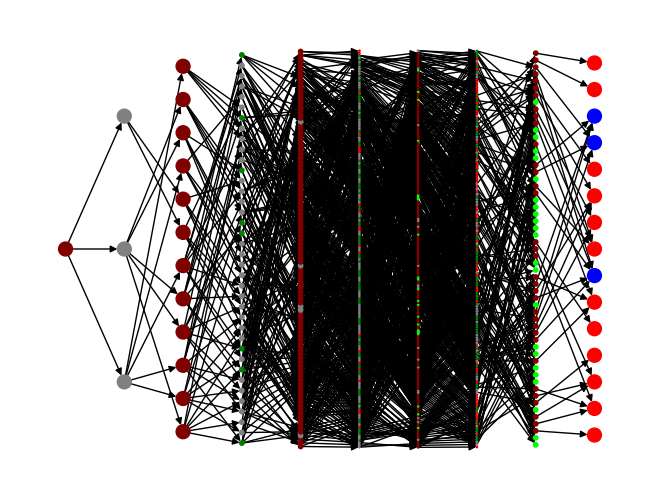

In [ ]:
#full game tree - equal spread

nx.draw(gametree,
        pos=nx.get_node_attributes(gametree,'spread'), 
        #pos=nx.spring_layout(gametree),
        #labels=nx.get_node_attributes(gametree, 'label'),
        node_color=tuple(nx.get_node_attributes(gametree,'color').values()), 
        node_size = tuple(nx.get_node_attributes(gametree,'size').values()),
        font_size = 2,
        edge_color=(0,0,0),
        #with_labels=True, 
        )

#plt.savefig("test.png", dpi = 2000)

In [ ]:
#TEST BESTMOVE:
def testai(board, stack):
  aimove = board.bestmove()[0]
  newstack = stack
  newstack.append(aimove)
  newboard = board.move(aimove)
  if(newboard.iswin()):
    return 
  for move in newboard.moves():
    if(move.iswin() != False):
      raise Exception("AI lost!: " + repr(newstack))
    testai(move, newstack)

#testai(Tictactoe(), [])

In [ ]:
#PLAY AGAINST BESTMOVE:

def humangame():
  def treeturn(board):
    computermove = board.bestmove()
    print(computermove)
    if(computermove == False):
      print("Computer has no clue what to do.")
      board = board.moves()[0]
    else:
      board = board.move(computermove[0])
    return board
  def humanturn(board):
    print(board)
    humanmove = input("Your move:")
    board = board.move(int(humanmove))
    return board
  #finally: game
  board = Tictactoe()
  if(input("X or O?: ") == 'X'):
    players = (humanturn, treeturn)
  else:
    players = (treeturn, humanturn)
  while True:
    board = players[0](board)
    if(board.iswin()): break
    board = players[1](board)
    if(board.iswin()): break
  print(board)
  print(board.iswin(), "wins!")


#humangame() #uncomment me out to play